In [2]:
from transformers import BertConfig, BertForSequenceClassification, AutoTokenizer
import torch

# Load the configuration
config_path = 'E:/Users/UgurS/Desktop/2.Desktop/7. Semester\Bachelorarbeit\Bachelorarbeit\models\model_epoch3_lr2e-05_bs16_20240105-005419\epoch_3'  # Replace with your config directory
config = BertConfig.from_pretrained(config_path, output_hidden_states=False)

model_name = 'ahmedrachid/FinancialBERT'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create the model
model = BertForSequenceClassification(config)

# Load the weights
model_weights = 'E:/Users/UgurS/Desktop/2.Desktop/7. Semester\Bachelorarbeit\Bachelorarbeit\models\model_epoch3_lr2e-05_bs16_20240105-005419\epoch_3/pytorch_model.bin'  # Replace with your model weights file
model.load_state_dict(torch.load(model_weights))

# # Set the model to evaluation mode
# model.eval()

# text_to_classify = """Yields, which move inversely to prices, had been trading around 3 or 4 basis points (bps) lower in early European trading but reversed course as data was released."""
# # Tokenize the input text and convert to tensors
# inputs = tokenizer(text_to_classify, padding=True, truncation=True, max_length=512, return_tensors="pt")

# # Move the model to the correct device (GPU or CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# inputs = {k: v.to(device) for k, v in inputs.items()}

# # Get predictions
# with torch.no_grad():
#     outputs = model(**inputs)
#     predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

# # Move predictions to CPU and convert to numpy
# predictions = predictions.detach().cpu().numpy()

# # Get the predicted class index
# predicted_class_index = predictions.argmax(axis=-1)

# # Map the predicted class index to the actual label
# # This step depends on how you've set up your labels. Assuming you have a label mapping like below.
# label_map = {0: 'positive', 1: 'neutral', 2: 'negative'}
# predicted_label = label_map[predicted_class_index[0]]
# print(f"Predicted label: {predicted_label}")


<All keys matched successfully>

In [3]:
import sqlite3
from sklearn.model_selection import train_test_split

# Connect to the database
conn = sqlite3.connect('data/sentiment.db')
cursor = conn.cursor()

# Fetch the data from the "sentences" table
cursor.execute("SELECT sentence_text, final_sentiment FROM sentences WHERE final_sentiment != 'manual'")
data = cursor.fetchall()

# Close the database connection
conn.close()

# Convert data to a dictionary with the keys "text" and "label"
data = [{"text": text, "label": label} for text, label in data]
# Convert bullish to 0, neutral to 1, and bearish to 2
data = [{"text": row["text"], "label": 0 if row["label"] == "bullish" else 1 if row["label"] == "neutral" else 2} for row in data]

# Split the data into train, test, and validation sets
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

# Print the sizes of the train, test, and validation sets
print("Train data percentage:", (round((len(train_data) / len(data)) * 100)))
print("Test data percentage:", (round((len(test_data) / len(data)) * 100)))
print("Validation data percentage:", (round((len(val_data) / len(data)) * 100)))

Train data percentage: 72
Test data percentage: 15
Validation data percentage: 13


In [4]:
from transformers import AutoTokenizer
import torch

# Lade den Tokenizer
model_name = 'ahmedrachid/FinancialBERT'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Funktion, um die Daten zu tokenisieren
def tokenize_data(data):
    tokenized_data = []
    for item in data:
        # Tokenisiere den Text und füge das Ergebnis dem Array hinzu
        encoding = tokenizer(
            item['text'],
            padding='max_length',  # Pad kürzere Sätze
            truncation=True,       # Schneide längere Sätze ab
            max_length=512,        # Maximale Länge auf BERT's limit setzen
            return_tensors='pt'    # Rückgabe als PyTorch Tensoren
        )
        tokenized_data.append({'input_ids': encoding['input_ids'].squeeze(0), 'attention_mask': encoding['attention_mask'].squeeze(0), 'label': item['label']})
    return tokenized_data

# Tokenisiere Trainings-, Test- und Validierungsdaten
train_data_tokenized = tokenize_data(train_data)
val_data_tokenized = tokenize_data(val_data)
test_data_tokenized = tokenize_data(test_data)

In [5]:
from torch.utils.data import Dataset

# Erstelle eine benutzerdefinierte Dataset-Klasse
class SentimentDataset(Dataset):
    def __init__(self, tokenized_data):
        self.tokenized_data = tokenized_data

    def __len__(self):
        return len(self.tokenized_data)

    def __getitem__(self, idx):
        return self.tokenized_data[idx]

# Erstelle PyTorch Datasets
train_dataset = SentimentDataset(train_data_tokenized)
val_dataset = SentimentDataset(val_data_tokenized)
test_dataset = SentimentDataset(test_data_tokenized)

In [6]:
from torch.utils.data import DataLoader

batch_size = 16

# Erstelle DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
import evaluate

# Überprüfen, ob CUDA verfügbar ist und eine GPU zuweisen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Modell auf die GPU verschieben

model.eval()  # Schalte das Modell in den Evaluierungsmodus

total_eval_accuracy = 0
total_eval_loss = 0

# Lade die Metriken
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

for batch in test_loader:  # Verwende den Test-DataLoader
    # Übertrage die Batch-Daten auf das richtige Device (z.B. GPU)
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():  # Deaktiviere die Gradientenberechnung für die Evaluation
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    # Konvertiere die Ausgaben des Modells in Vorhersagen
    logits = outputs.logits if hasattr(outputs, "logits") else outputs[0]
    predictions = torch.argmax(logits, dim=-1)

    # Aktualisiere die Metriken mit den Vorhersagen und den wahren Labels
    accuracy_metric.add_batch(predictions=predictions, references=labels)
    f1_metric.add_batch(predictions=predictions, references=labels)
    precision_metric.add_batch(predictions=predictions, references=labels)
    recall_metric.add_batch(predictions=predictions, references=labels)
    
    # Berechne den Verlust und akkumuliere den Gesamtverlust.
    loss = outputs.loss
    total_eval_loss += loss.item()

    # Hier kannst du zusätzliche Metriken hinzufügen, wie z.B. die Genauigkeit.

# Berechne die durchschnittliche Verlust über alle Testbatches
avg_test_loss = total_eval_loss / len(test_loader)
print("Test Loss: ", avg_test_loss)

# Berechne die finale Metrik
final_accuracy = accuracy_metric.compute()
final_f1 = f1_metric.compute(average="weighted")  # oder andere Durchschnittswerte je nach Bedarf
final_precision = precision_metric.compute(average="weighted")
final_recall = recall_metric.compute(average="weighted")

print("Accuracy:", final_accuracy)
print("F1-Score:", final_f1)
print("Precision:", final_precision)
print("Recall:", final_recall)

Test Loss:  0.32007073698951766
Accuracy: {'accuracy': 0.9089214380825565}
F1-Score: {'f1': 0.908852133005905}
Precision: {'precision': 0.909345473013651}
Recall: {'recall': 0.9089214380825565}


In [8]:
from sklearn.metrics import confusion_matrix
import numpy as np

true_labels_list = []
predictions_list = []

# Angenommen, dies ist deine Validierungsschleife oder ein separater Evaluierungsprozess
for batch in test_loader:  # oder test_loader
    inputs, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['label']
    inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)  # Stelle sicher, dass sie auf dem richtigen Gerät sind

    with torch.no_grad():
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        # Hier bekommen wir die Logits (die Rohausgabe des Modells vor der Anwendung der Aktivierungsfunktion).
        logits = outputs.logits  # oder outputs[0], abhängig von deinem Modell

        # Bestimme die Klasse mit der höchsten Score für jede Eingabe in der Batch
        _, predictions = torch.max(logits, dim=1)

    # Sammle die wahren Labels und die Vorhersagen
    true_labels_list.extend(labels.cpu().numpy())
    predictions_list.extend(predictions.cpu().numpy())

# Nachdem du alle Vorhersagen gesammelt hast, konvertiere Listen in Arrays
true_labels = np.array(true_labels_list)
predictions = np.array(predictions_list)


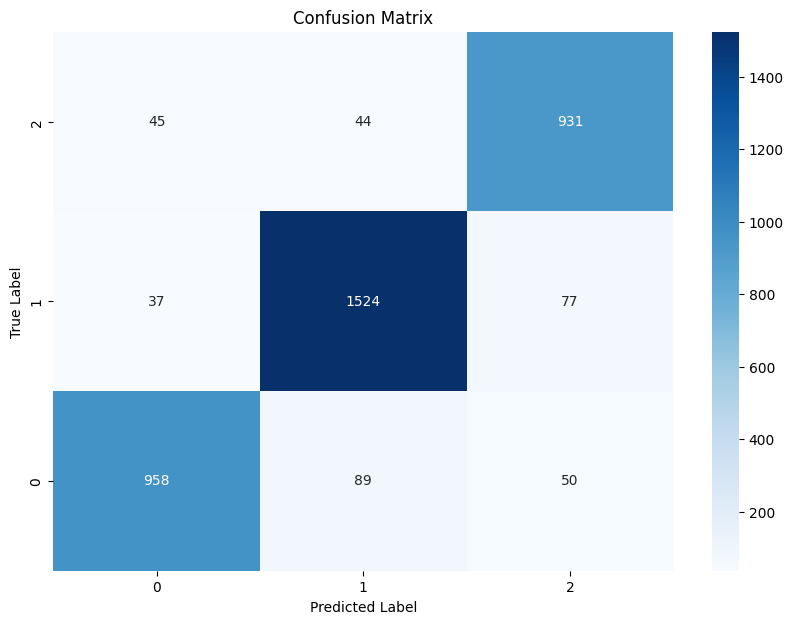

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Berechne die Konfusionsmatrix
cm = confusion_matrix(true_labels, predictions)

# Umdrehen der Matrix, so dass die Klasse 0 unten links ist
cm_flipped = np.flipud(cm)

# Visualisiere die umgedrehte Konfusionsmatrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_flipped, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Korrigiere die y-Achsen-Beschriftungen
# plt.yticks() nimmt zwei Argumente: Die Positionen und die Labels der Ticks
# Wir stellen die Positionen so ein, dass sie auf die Mitte der Kästen zeigen
plt.yticks(np.arange(0.5, len(cm)), labels=np.arange(len(cm))[::-1])

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import re

# Step 1: Read the file and extract learning rates and epochs.
learning_rates = []
epochs = []
losses = []

with open('TrainingData.txt', 'r') as file:
    for line in file:
        if 'learning_rate' in line and 'epoch' in line:
            # Extracting learning rate and epoch using regular expression
            lr_found = re.search("'learning_rate': (.*?),", line)
            loss_found = re.search("'loss': (.*?),", line)
            epoch_found = re.search("'epoch': (.*?)}", line)

            if lr_found and epoch_found:
                learning_rates.append(float(lr_found.group(1)))
                losses.append(float(loss_found.group(1)))
                epochs.append(float(epoch_found.group(1)))

plt.figure(figsize=(10, 6))
plt.plot(epochs, learning_rates)
plt.title('Learning Rate over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

# Step 3: Plot the data using matplotlib.
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
